In [50]:
import matplotlib.colors as colors
import os
import re
import string
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,roc_auc_score,\
                            r2_score, mean_squared_error, recall_score, precision_recall_curve

In [ ]:
bucket = 'group7bucketnew'
file_key = ['sample.feather']
s3uri = []
for i in file_key:
    s3uri.append('s3://{}/{}'.format(bucket, i))

In [ ]:
data = pd.DataFrame()
for i in s3uri:
    df = pd.read_feather(i)
    df["origin"] = i[21:]
    data = data.append(df)

In [21]:
# df = pd.read_csv('sample.csv',index_col=None, header=0, engine='python' )
#df = pd.read_feather('sample.feather')
#df.head()

,index,video_id,title,publishedAt,published_date,published_month,published_day,published_time,published_hour,channelId,...,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,origin
0,41983,GzqOZ9QVZ_4,Meghan Markle Says Kate Middleton Made Her Cry...,2021-03-08 02:50:34,2021-03-08,March,Monday,02:50:34,2,UCiKGMZZmZXK-RpbKJGXgH3Q,...,Access|meghan markle|prince harry|royals|kate ...,1406056,8497,3467,5570,https://i.ytimg.com/vi/GzqOZ9QVZ_4/default.jpg,False,False,Meghan Markle is setting the record straight. ...,FR_youtube_trending_data.csv
1,91206,O5Vd-I1gd7Y,ANUEL AA || BZRP Music Sessions #46,2021-11-03 22:00:07,2021-11-03,November,Wednesday,22:00:07,22,UCmS75G-98QihSusY7NfCZtw,...,bizarrap|biza|bisa|bizzarrap|bzrp|bzrp music s...,12407815,1368606,47020,135238,https://i.ytimg.com/vi/O5Vd-I1gd7Y/default.jpg,False,False,ANUEL AA || BZRP Music Sessions #46Lyrics by: ...,US_youtube_trending_data.csv
2,161511,Rp54Lnej9WY,‘서희원♥️구준엽’부부 케미퀴즈 너무 스윗하다! 다시 만날 때 눈물 터진 기억 한달...,2022-10-25 11:00:05,2022-10-25,October,Tuesday,11:00:05,11,UCKl0gSq0JOcdzXTrS4gk2cg,...,cne-tw|dj koo|dj koo 大s|vogue|vogue quiz|vogue...,2492614,28219,0,2235,https://i.ytimg.com/vi/Rp54Lnej9WY/default.jpg,False,False,【🚨자막수정 공지】4:56 잘못된 자막 ‘10년전’을 ‘20년전’으로 자막 수정합니...,KR_youtube_trending_data.csv
3,114544,tYqUZapdjzE,『ストリートファイター6』ティザー映像,2022-02-21 05:34:57,2022-02-21,February,Monday,05:34:57,5,UCyuEAZQzRqhcaLZvQd9ZUNA,...,[None],413789,4731,0,0,https://i.ytimg.com/vi/tYqUZapdjzE/default.jpg,True,False,待望となるシリーズおよびナンバリングの最新作『ストリートファイター6』の制作が決定！この夏、...,JP_youtube_trending_data.csv
4,163429,HlkORTHy8DU,Big Changes Coming (channel update),2022-10-30 15:00:08,2022-10-30,October,Sunday,15:00:08,15,UC4laAHbk8VSgmvB47tsd2XQ,...,van life|living in a van|vanlife|eamon and bec...,589956,31990,0,9406,https://i.ytimg.com/vi/HlkORTHy8DU/default.jpg,False,False,Shop our limited edition Breast Cancer Awarene...,CA_youtube_trending_data.csv


In [31]:
df['publishedAt_year'] = df['publishedAt'].dt.year
df['publishedAt_month'] = df['publishedAt'].dt.month
df['publishedAt_day'] = df['publishedAt'].dt.day
df['publishedAt_hour'] = df['publishedAt'].dt.hour
df['publishedAt_minute'] = df['publishedAt'].dt.minute
df['publishedAt_dayofweek'] = df['publishedAt'].dt.dayofweek

In [20]:
!pip list | grep pandas

pandas                               1.2.4


In [32]:
print(df.shape[0]-df.drop_duplicates().shape[0])
# 1222 duplicated rows

df = df.drop_duplicates()

0


In [33]:
unique_videos = df[['title','video_id']].drop_duplicates()
print("Size of the original dataset: {}".format(len(df)))
print("Number of unique videos in the dataset: {}".format(len(unique_videos)))

#Some videos are repeated, but with different trending dates

titles_count = df['title'].value_counts()
df['trending_time'] = df.apply(lambda x: titles_count[x['title']],axis=1)
# Trending_time is the number of days in trending

Size of the original dataset: 10118
Number of unique videos in the dataset: 9703


In [34]:
print(df.columns)

columns_floats = ['view_count', 'likes', 'dislikes','comment_count','comments_disabled', 'ratings_disabled']
columns_dates = ['trending_date','publish_time']

Index(['index', 'video_id', 'title', 'publishedAt', 'published_date',
       'published_month', 'published_day', 'published_time', 'published_hour',
       'channelId', 'channelTitle', 'categoryId', 'trendingAt',
       'trending_date', 'trending_time', 'trending_hour', 'trending_month',
       'trending_day', 'tags', 'view_count', 'likes', 'dislikes',
       'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description', 'origin', 'publishedAt_year',
       'publishedAt_month', 'publishedAt_day', 'pub　lishedAt_hour',
       'publishedAt_minute', 'publishedAt_dayofweek', 'liked', 'ratings',
       'publishedAt_hour'],
      dtype='object')


<AxesSubplot:>

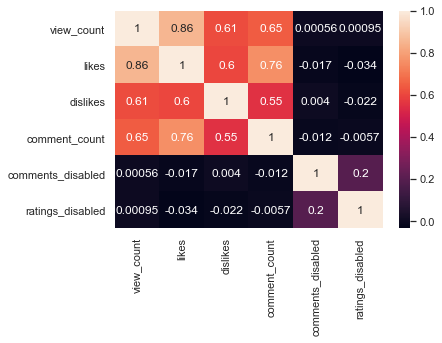

In [35]:
sns.heatmap(df[columns_floats].corr(),annot=True)

In [36]:
def TransformLikes(DF):
    DF['liked'] = DF.apply(lambda x: x.likes/(x.likes+x.dislikes+1e-10),axis=1)
    DF['ratings']= DF.apply(lambda x: x.likes+x.dislikes,axis=1)

TransformLikes(df)

In [37]:
columns_floats = ['view_count',
                  #'likes',
                  #'dislikes',
                  'liked',
                  'ratings',
                  'comments_disabled',
                  'comment_count',
                  'ratings_disabled',
                  'publishedAt_month',
                  'publishedAt_day',
                  'publishedAt_hour']

df[columns_floats].corr()

,view_count,liked,ratings,comments_disabled,comment_count,ratings_disabled,publishedAt_month,publishedAt_day,publishedAt_hour
view_count,1.000000,0.005012,0.857071,0.000563,0.648212,0.000945,0.001836,0.011712,-0.050919
liked,0.005012,1.000000,0.044522,-0.205282,0.008231,-0.950549,-0.024965,-0.007697,0.048255
ratings,0.857071,0.044522,1.000000,-0.017214,0.761688,-0.033811,0.013654,0.013779,-0.043501
comments_disabled,0.000563,-0.205282,-0.017214,1.000000,-0.012114,0.198892,-0.006642,0.013854,-0.027888
comment_count,0.648212,0.008231,0.761688,-0.012114,1.000000,-0.005717,0.003003,-0.003209,-0.049193
ratings_disabled,0.000945,-0.950549,-0.033811,0.198892,-0.005717,1.000000,0.021350,0.016316,-0.045188
publishedAt_month,0.001836,-0.024965,0.013654,-0.006642,0.003003,0.021350,1.000000,0.007053,0.016620
publishedAt_day,0.011712,-0.007697,0.013779,0.013854,-0.003209,0.016316,0.007053,1.000000,0.008974
publishedAt_hour,-0.050919,0.048255,-0.043501,-0.027888,-0.049193,-0.045188,0.016620,0.008974,1.000000


In [38]:
def remove_punc(text):
    text = text.replace('|',' ')
    text = "".join([chart for chart in text if chart not in string.punctuation])

    return text

df['tags_clean'] = df['tags'].apply(lambda x: remove_punc(x))

In [39]:
def tokenizer(text):
    tokens = re.split('\W+',text)
    return tokens

df['tokens'] = df['tags_clean'].apply(lambda x: tokenizer(x.lower()))

In [40]:
nltk.download('stopwords')
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_sp = nltk.corpus.stopwords.words('spanish')

stopwords = stopwords_en + stopwords_sp

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilyziyixiao/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
def remove_stopwords(tokens):
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

df['tokens'] = df['tokens'].apply(lambda x: remove_stopwords(x))

In [42]:
def remove_numb(tokens):
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

df['tokens'] = df['tokens'].apply(lambda x: remove_numb(x))

In [43]:
unique_videos = df[['title','video_id']].drop_duplicates()

c = Counter()
def counter(text):
    c.update(text)
df.loc[unique_videos.index,'tokens'].apply(lambda x: counter(x))

common_words_1 = [word[0] for word in c.most_common()[:300]]

In [44]:
mono_words = list()
for word in common_words_1:
    if len(word)==1:
        mono_words.append(word)

for word in mono_words:
    common_words_1.remove(word)

In [45]:
for word in common_words_1:
    df[word] = df['tokens'].apply(lambda x: x.count(word))

In [46]:
unique_videos = df[['title']].drop_duplicates()

X_train,X_test = train_test_split(unique_videos,test_size=0.2)

columns  = ['liked',
            'ratings',
            'comments_disabled',
            'comment_count',
            'ratings_disabled',
            'publishedAt_month',
            'publishedAt_day',
            'publishedAt_hour'] + common_words_1

X_train = df.loc[X_train.index,columns]
X_test = df.loc[X_test.index,columns]

countries_train = df.loc[X_train.index]
countries_test = df.loc[X_test.index]

#oh_country = OneHotEncoder(sparse=False)

#countries_train = pd.DataFrame(oh_country.fit_transform(countries_train.values.reshape(-1,1)),index = countries_train.index)
#countries_test = pd.DataFrame(oh_country.transform(countries_test.values.reshape(-1,1)),index = countries_test.index)
#X_train = pd.concat([X_train,countries_train],axis=1)
#X_test = pd.concat([X_test,countries_test],axis=1)

y_train = df.loc[X_train.index,'view_count']
y_train = y_train[~y_train.index.duplicated(keep='first')]
y_test = df.loc[X_test.index,'view_count']
y_test = y_test[~y_test.index.duplicated(keep='first')]
X_train = X_train[~X_train.index.duplicated(keep='first')]
X_test = X_test[~X_test.index.duplicated(keep='first')]

In [48]:
columns_scaled  = ['liked',
                   'ratings',
                   'comments_disabled',
                   'comment_count',
                   'ratings_disabled',
                   'publishedAt_month',
                   'publishedAt_day',
                   'publishedAt_hour'] #+ common_words_1

scaler = StandardScaler()

X_train[columns_scaled] = scaler.fit_transform(X_train[columns_scaled])
X_test[columns_scaled] = scaler.transform(X_test[columns_scaled])

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

X_train[common_words_1] = minmax.fit_transform(X_train[common_words_1])
X_test[common_words_1] = minmax.transform(X_test[common_words_1])

In [49]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1,random_state=0, class_weight='balanced',solver='newton-cg')
clf.fit(X_train,y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=0,
                   solver='newton-cg')

In [55]:
from sklearn.metrics import mean_squared_error
y_predict = clf.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_predict, y_test))
RMSE_test

4005028.439751809

In [56]:
modify_rmse = 1012039/RMSE_test
modify_rmse

0.25269208826460066

# 咱就是说……要不计个时？

In [62]:
import datetime

In [63]:
start = datetime.datetime.now()

In [64]:
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced',loss="squared_hinge",penalty="l2")
svc.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(class_weight='balanced')

In [65]:
y_predict = svc.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_predict, y_test))
RMSE_test

5308698.604724238

In [66]:
modify_rmse = 1012039/RMSE_test
modify_rmse

0.1906378710404432

In [67]:
end = datetime.datetime.now()
interval = end - start
print(interval)

0:06:49.190213


In [ ]:
start = datetime.datetime.now()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000,
                            max_depth=None,
                            criterion='entropy',
                            )
rf.fit(X_train,y_train)

In [ ]:
y_predict = rf.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_predict, y_test))
RMSE_test

In [ ]:
modify_rmse = 1012039/RMSE_test
modify_rmse

In [ ]:
end = datetime.datetime.now()
interval = end - start
print(interval)